# Verify Objaverse Renders

This notebook verifies rendered images from the specified directory (default: `./debug` or `~/.objaverse/renders`) by:
- Finding all zip files
- Selecting random renders
- Extracting and visualizing all pass outputs (RGB, Depth, Normals, Mask) for selected views
- Showing relevant metadata

In [6]:
import os
import json
import random
import zipfile
import tempfile
from pathlib import Path
from io import BytesIO
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from IPython.display import display, HTML

# Set random seed for reproducibility
random.seed(42)

# Enable OpenEXR for OpenCV
os.environ['OPENCV_IO_ENABLE_OPENEXR'] = '1'
import cv2

## Find Rendered Zip Files

In [7]:
# Define the renders directory
renders_dir = Path("./debug")
# renders_dir = Path.home() / ".objaverse" / "renders"


# Find all zip files recursively
zip_files = list(renders_dir.rglob("*.zip"))

print(f"Found {len(zip_files)} zip files in {renders_dir}")

# Select up to 5 random zip files for detailed verification
num_to_verify = min(5, len(zip_files))
selected_zips = random.sample(zip_files, num_to_verify)

print(f"Selected {num_to_verify} zip files for verification")

Found 1 zip files in debug
Selected 1 zip files for verification


## Helper Functions

In [8]:
def extract_view_data_from_zip(zip_path, num_views=1):
    """
    Extracts random views and all their passes from a zip file.
    
    Args:
        zip_path: Path to the zip file
        num_views: Number of views to verify per object
    
    Returns:
        tuple: (metadata, list of dicts with images)
        Each dict in the list contains keys: 'RGB', 'Depth', 'Normals', 'Mask', 'Name'
    """
    view_data_list = []
    metadata = None
    
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        all_files = zip_ref.namelist()
        
        # Find base RGB files (e.g., '000.png') to identify views
        # Exclude mask files (e.g. '000_mask.png') and any other non-root renders
        rgb_files = [f for f in all_files 
                     if f.endswith('.png') and 
                     'mask' not in os.path.basename(f) and 
                     os.path.basename(f)[0].isdigit()]
        
        # Find metadata.json
        metadata_files = [f for f in all_files if f.endswith('metadata.json')]
        if metadata_files:
            with zip_ref.open(metadata_files[0]) as meta_file:
                metadata = json.load(meta_file)
        
        selected_rgb = random.sample(rgb_files, min(num_views, len(rgb_files)))
        
        # Create a temp directory to extract files for cv2 loading
        with tempfile.TemporaryDirectory() as temp_dir:
            for base_rgb in selected_rgb:
                # Determine view ID/prefix from the RGB filename
                # e.g. 'subdir/000.png' -> 'subdir/' and '000'
                dirname = os.path.dirname(base_rgb)
                basename = os.path.basename(base_rgb)
                view_id = os.path.splitext(basename)[0]
                
                # Construct expected paths for other passes
                files_to_extract = {
                    "RGB": base_rgb,
                    "Depth": os.path.join(dirname, f"{view_id}_depth.exr"),
                    "Normals": os.path.join(dirname, f"{view_id}_normal.exr"),
                    "Mask": os.path.join(dirname, f"{view_id}_mask.png")
                }
                
                extracted_paths = {}
                images = {"Name": base_rgb}
                
                # Extract available files
                for name, path in files_to_extract.items():
                    if path in all_files:
                        extracted_path = zip_ref.extract(path, temp_dir)
                        extracted_paths[name] = extracted_path
                
                # Load images using cv2 logic
                for name, path in extracted_paths.items():
                    if path.endswith('.exr'):
                        img = cv2.imread(path, cv2.IMREAD_UNCHANGED)
                    else:
                        img = cv2.imread(path)
                        if name == "RGB":
                            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                        elif name == "Mask":
                            if len(img.shape) == 3:
                                img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
                    
                    if img is not None:
                        images[name] = img
                
                view_data_list.append(images)
                
    return metadata, view_data_list


def display_render_verification(zip_path, metadata, view_data_list):
    """
    Display all passes for the extracted views.
    """
    uid = zip_path.stem
    print("=" * 80)
    print(f"UID: {uid}")
    print("=" * 80)
    
    if metadata:
        print(f"SHA256: {metadata.get('sha256', 'N/A')}")
        print(f"Mesh Count: {metadata.get('mesh_count', 'N/A')}")
        print(f"Vertex Count: {metadata.get('vert_count', 'N/A')}")
    
    for i, images in enumerate(view_data_list):
        print(f"\nView #{i+1}: {images.get('Name', 'Unknown')}")
        
        # Setup plot
        fig, axes = plt.subplots(2, 2, figsize=(12, 12))
        ax_flat = axes.flatten()
        
        # Order of display
        passes = ["RGB", "Depth", "Normals", "Mask"]
        mask_img = images.get("Mask")
        
        for idx, pass_name in enumerate(passes):
            ax = ax_flat[idx]
            ax.set_title(pass_name)
            
            img = images.get(pass_name)
            if img is None:
                ax.text(0.5, 0.5, "Not Found", ha='center', va='center')
                ax.axis('off')
                continue
                
            if pass_name == "Normals":
                vis_img = img.copy()
                # Handle 2-channel normals (common in some EXR outputs)
                if vis_img.ndim == 3 and vis_img.shape[2] == 2:
                    x = vis_img[:,:,0]
                    y = vis_img[:,:,1]
                    z_sq = 1.0 - x**2 - y**2
                    z = np.sqrt(np.maximum(z_sq, 0))
                    vis_img = np.dstack((x, y, z))
                
                # Map [-1, 1] to [0, 1] if needed
                if vis_img.min() < 0:
                    vis_img = (vis_img + 1) / 2
                vis_img = np.clip(vis_img, 0, 1)
                ax.imshow(vis_img)
                
            elif pass_name == "Depth":
                if img.ndim == 3:
                     img_view = img[:,:,0]
                else:
                     img_view = img

                img_valid = img_view.copy()
                vmin, vmax = None, None
                
                if mask_img is not None:
                    valid_mask = mask_img > 127
                    # Check if shapes match (just in case)
                    if valid_mask.shape == img_valid.shape:
                        img_valid = np.where(valid_mask, img_valid, np.nan)
                        valid_pixels = img_valid[~np.isnan(img_valid)]
                        if valid_pixels.size > 0:
                            vmin = np.nanpercentile(valid_pixels, 1)
                            vmax = np.nanpercentile(valid_pixels, 99)
                else:
                    # Fallback inf check
                    is_inf = np.isinf(img_view)
                    if is_inf.any():
                         img_valid[is_inf] = np.nan
                         valid_pixels = img_valid[~np.isnan(img_valid)]
                         if valid_pixels.size > 0:
                             vmin = np.nanpercentile(valid_pixels, 1)
                             vmax = np.nanpercentile(valid_pixels, 99)

                im = ax.imshow(img_valid, cmap='inferno', vmin=vmin, vmax=vmax)
                plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
                
            elif pass_name == "Mask":
                ax.imshow(img, cmap='gray')
            else: # RGB
                ax.imshow(img)
            
            ax.axis('off')
            
        plt.tight_layout()
        plt.show()

## Verify Renders

UID: c271fa5a84fd4a1a973ba7ef069a0975
SHA256: 52f9adcc8d989a9d5deece8fd6a0e8b68de7b1d5b87bfb27e6e56a65b7a6148f
Mesh Count: 10
Vertex Count: 598729

View #1: c271fa5a84fd4a1a973ba7ef069a0975/009.png


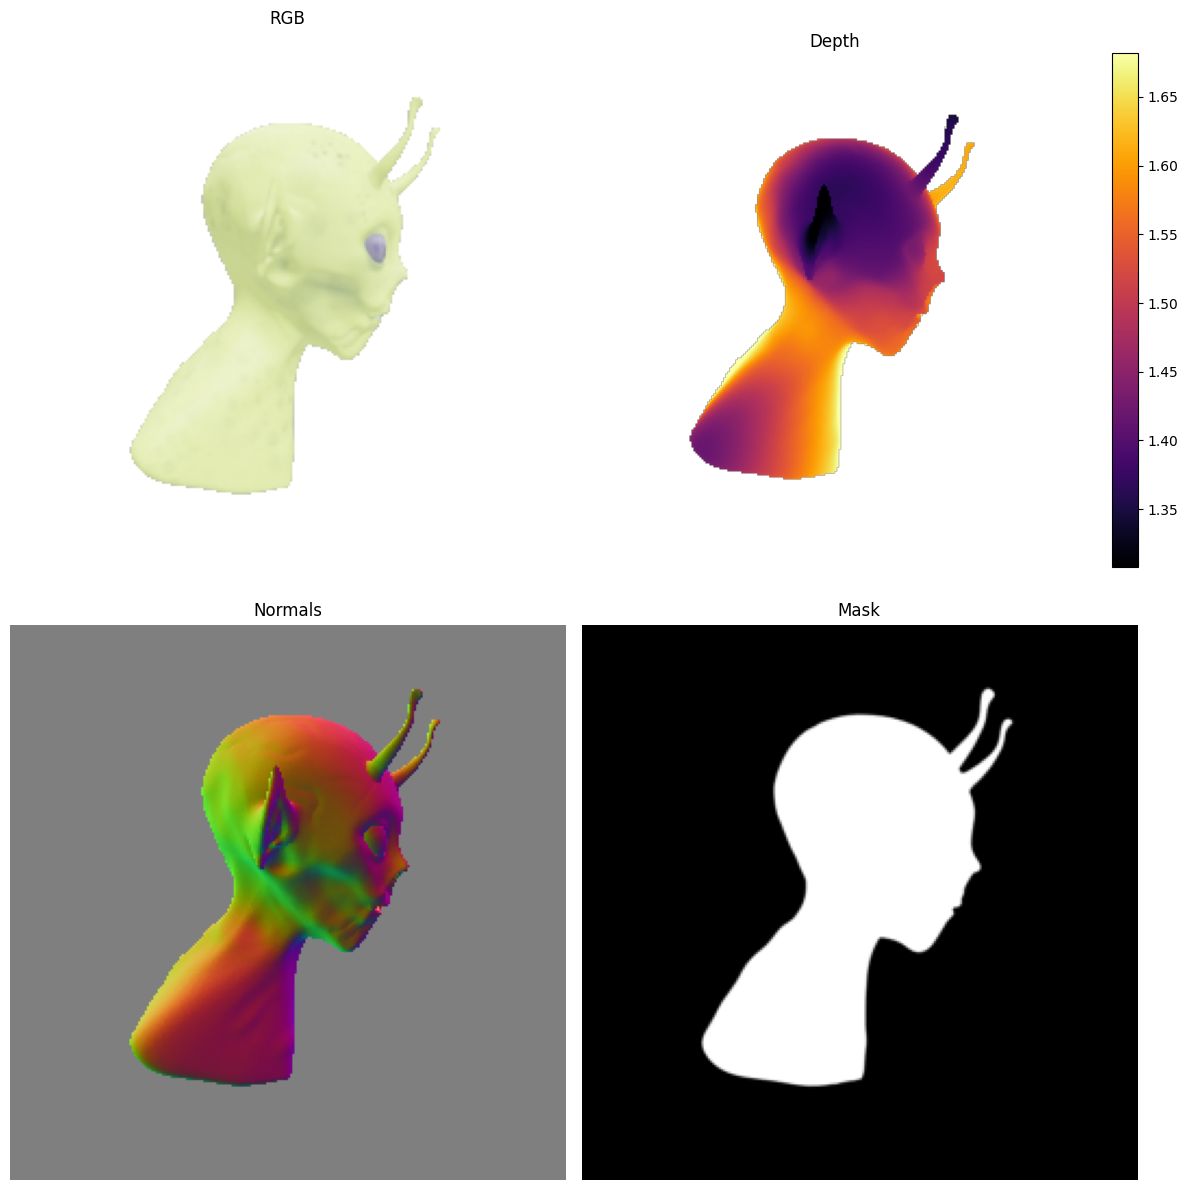


View #2: c271fa5a84fd4a1a973ba7ef069a0975/019.png


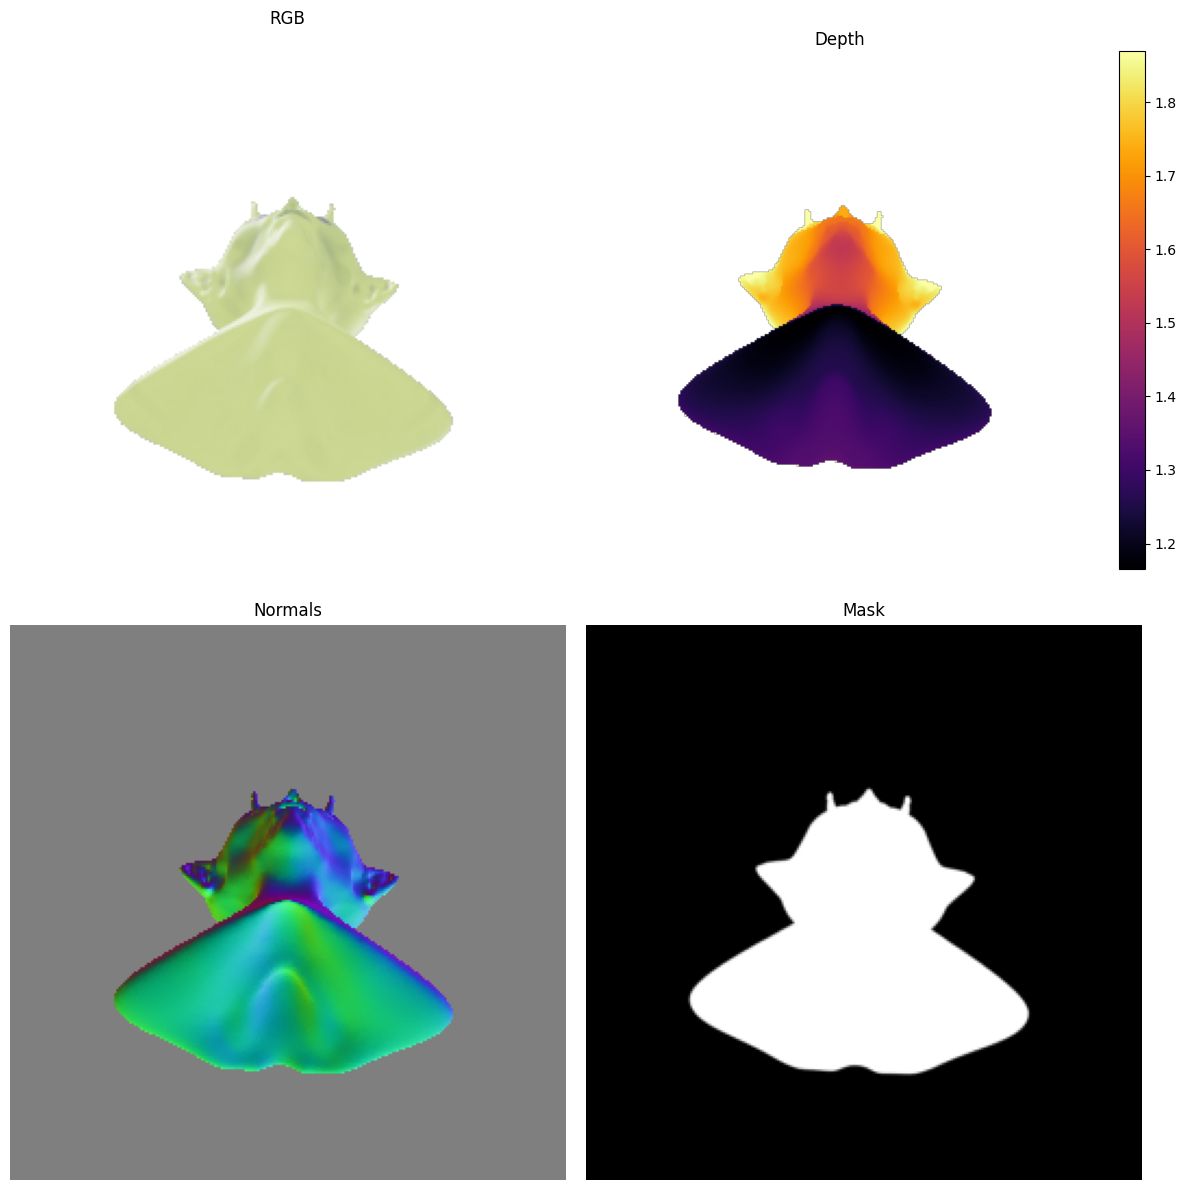

In [9]:
# Process each selected zip file
for zip_path in selected_zips:
    try:
        metadata, view_data_list = extract_view_data_from_zip(zip_path, num_views=2)
        display_render_verification(zip_path, metadata, view_data_list)
    except Exception as e:
        print(f"Error processing {zip_path.name}: {e}")
        import traceback
        traceback.print_exc()
        print("-" * 80)
        print()

## Summary Statistics

In [10]:
# Collect statistics from all zip files
print("Collecting statistics from all rendered files...")
print("=" * 80)

total_meshes = 0
total_verts = 0
total_polys = 0
valid_renders = 0
failed_renders = 0

for zip_path in zip_files:
    try:
        with zipfile.ZipFile(zip_path, 'r') as zip_ref:
            metadata_files = [f for f in zip_ref.namelist() if f.endswith('metadata.json')]
            if metadata_files:
                with zip_ref.open(metadata_files[0]) as meta_file:
                    metadata = json.load(meta_file)
                    total_meshes += metadata.get('mesh_count', 0)
                    total_verts += metadata.get('vert_count', 0)
                    total_polys += metadata.get('poly_count', 0)
                    valid_renders += 1
    except Exception as e:
        failed_renders += 1

print(f"Total renders found: {len(zip_files)}")
print(f"Valid renders: {valid_renders}")
print(f"Failed renders: {failed_renders}")
print(f"\nAggregate statistics:")
print(f"  Total meshes: {total_meshes:,}")
print(f"  Total vertices: {total_verts:,}")
print(f"  Total polygons: {total_polys:,}")
if valid_renders > 0:
    print(f"\nAverage per render:")
    print(f"  Meshes: {total_meshes / valid_renders:.1f}")
    print(f"  Vertices: {total_verts / valid_renders:,.0f}")
    print(f"  Polygons: {total_polys / valid_renders:,.0f}")

Total renders found: 1
Valid renders: 1
Failed renders: 0

Aggregate statistics:
  Total meshes: 10
  Total vertices: 598,729
  Total polygons: 199,986

Average per render:
  Meshes: 10.0
  Vertices: 598,729
  Polygons: 199,986
